In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from yellowbrick.target import FeatureCorrelation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [2]:
plt.style.use('dark_background')
data = pd.read_csv("b_depressed.csv")

In [3]:
data.drop(columns=["gained_asset", "durable_asset", "save_asset", "living_expenses",
"other_expenses", "incoming_agricultural", "farm_expenses", "lasting_investment", "no_lasting_investmen"], inplace=True)

In [4]:
data.shape

(1429, 14)

In [5]:
data.groupby("depressed").size()

depressed
0    1191
1     238
dtype: int64

In [6]:
data.groupby('depressed').size()/data.shape[0]

depressed
0    0.83345
1    0.16655
dtype: float64

## Exploratory data analysis

In [7]:
f_data = data[data['sex'] == 0]
m_data = data[data['sex'] == 1]

In [8]:
ym = m_data["depressed"]
xm = m_data.iloc[:, :-1]
yf = f_data["depressed"]
xf = f_data.iloc[:, :-1]

C:\Users\Vladi\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\Vladi\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


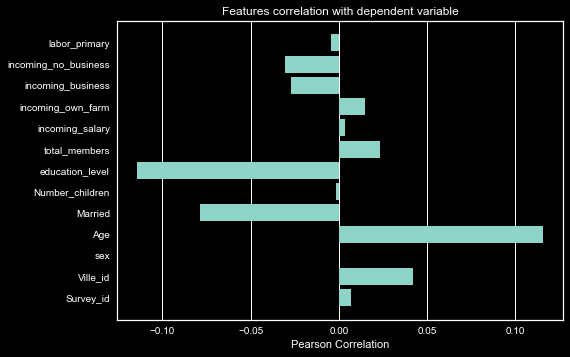

In [9]:
visualizer = FeatureCorrelation()
visualizer.fit(xm, ym)
visualizer.show()

Univariate Selection

In [10]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(xm, ym)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(xm.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Feature", "Score"]
print(featureScores.nlargest(10,"Score"))

                 Feature       Score
1               Ville_id  131.862959
3                    Age   95.759480
6        education_level   16.965285
0              Survey_id   15.736661
4                Married    1.558310
11  incoming_no_business    0.889328
10     incoming_business    0.860148
7          total_members    0.421913
9      incoming_own_farm    0.212580
12         labor_primary    0.019330


Feature Importance

[0.18721005 0.18757595 0.         0.18046479 0.01996002 0.1177951
 0.1423853  0.08781122 0.01252857 0.01926083 0.00983271 0.02106225
 0.0141132 ]


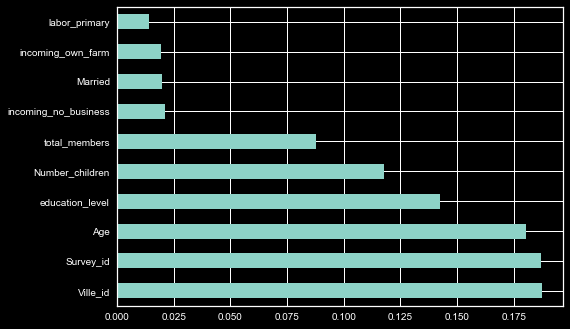

In [11]:
model = ExtraTreesClassifier()
model.fit(xm, ym)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=xm.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.show()

Heatmap

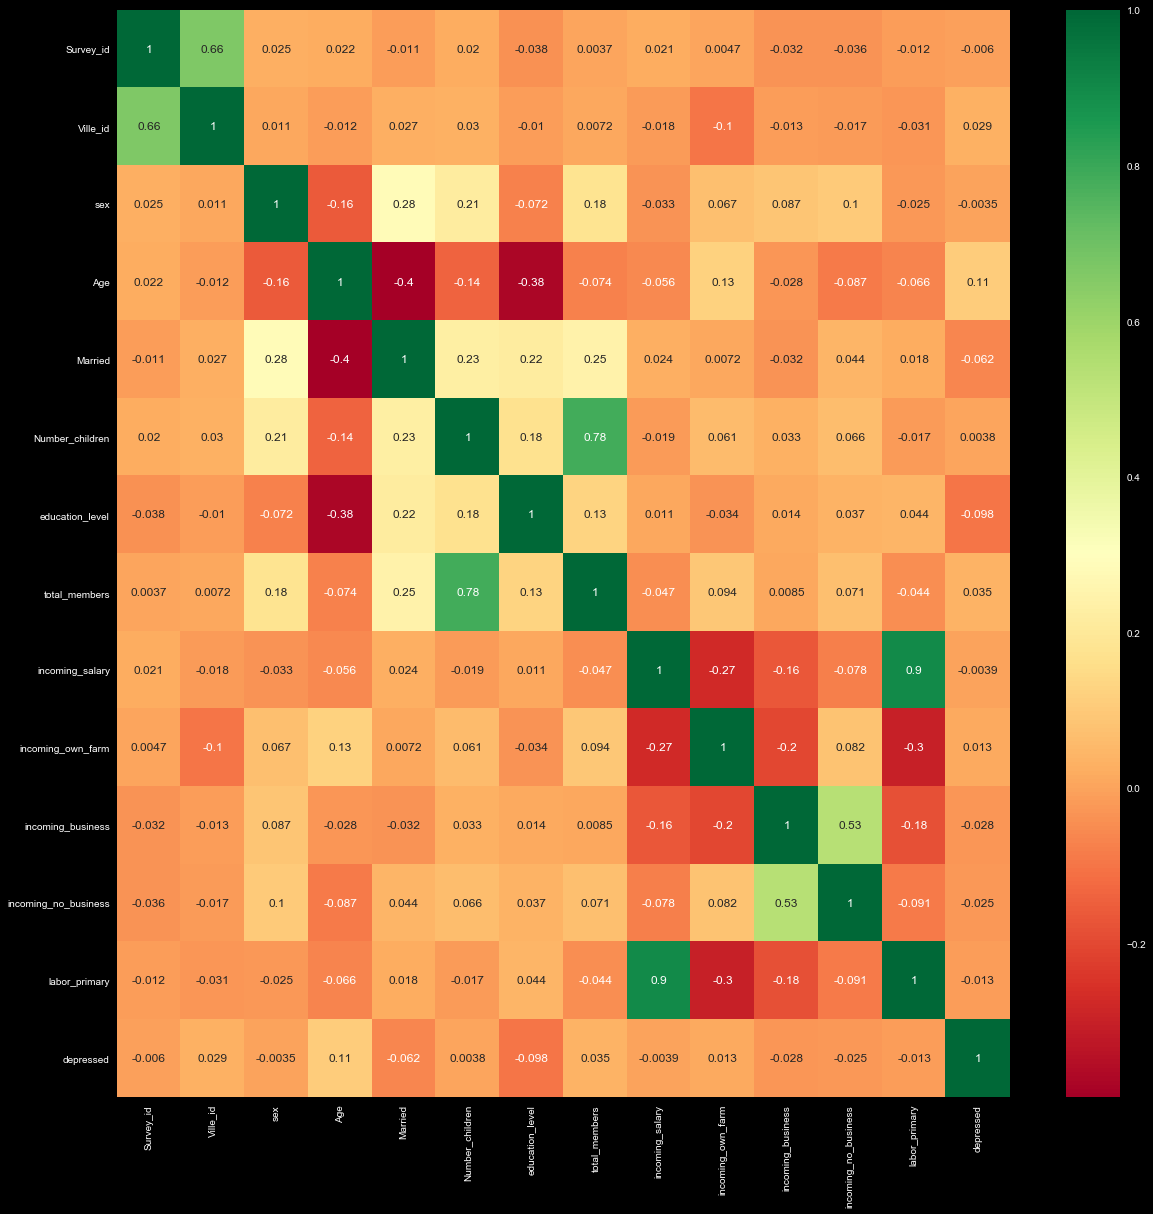

In [12]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [13]:
xm = xm[["Age", "education_level", "Married"]]

In [14]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

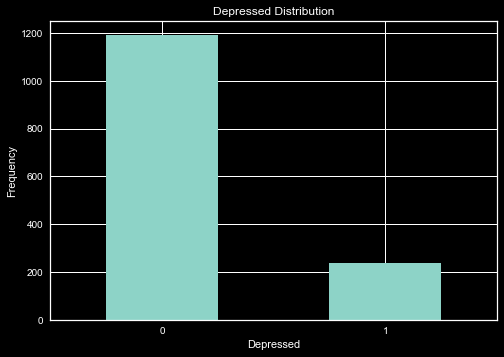

In [15]:
count_classes = pd.value_counts(data['depressed'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Depressed Distribution")
plt.xticks(range(2))
plt.xlabel("Depressed")
plt.ylabel("Frequency")

In [16]:
# Undersampling
nm = NearMiss()
xm, ym = nm.fit_sample(xm, ym)
xm.shape, ym.shape

((436, 3), (436,))

In [17]:
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym)
xf_train, xf_test, yf_train, yf_test = train_test_split(xf, yf)
scaler = StandardScaler()

In [18]:
scaler.fit(xm_train)
xm_train = scaler.transform(xm_train)
xm_test = scaler.transform(xm_test)

## Male Depression

In [19]:
def cm(y_test, y_pred):
    cmx = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(cmx)
    ax.xaxis.set(ticks=(0, 1), ticklabels=("Predicted 0s", "Predicted 1s"))
    ax.yaxis.set(ticks=(0, 1), ticklabels=("Actual 0s", "Actual 1s"))
    sns.heatmap(cmx, annot=True, cmap="YlGnBu", fmt="d")
    plt.tight_layout()
    plt.title("Confusion Matrix for Male Depression", y=1.1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    plt.show()

KNN

In [20]:
classifier = KNeighborsClassifier(n_neighbors=13)
classifier.fit(xm_train, ym_train)
ym_pred_knn = classifier.predict(xm_test)

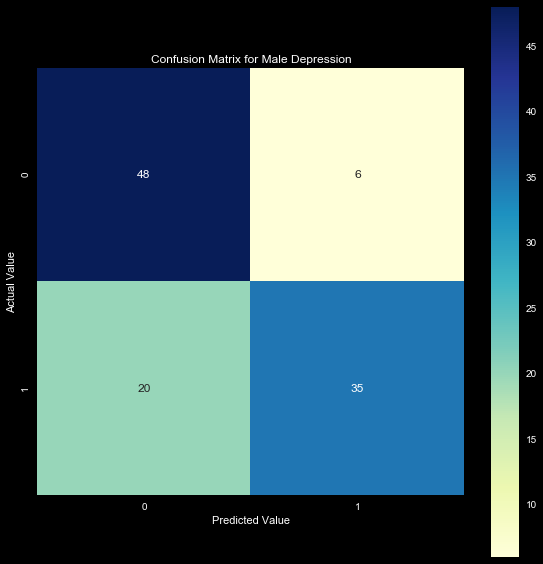

In [21]:
# Confusion Matrix
cm(ym_test, ym_pred_knn)

In [22]:
# Error Rate for K-value
error = []
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xm_train, ym_train)
    pred_i = knn.predict(xm_test)
    error.append(np.mean(pred_i != ym_test))

Text(0, 0.5, 'Mean Error')

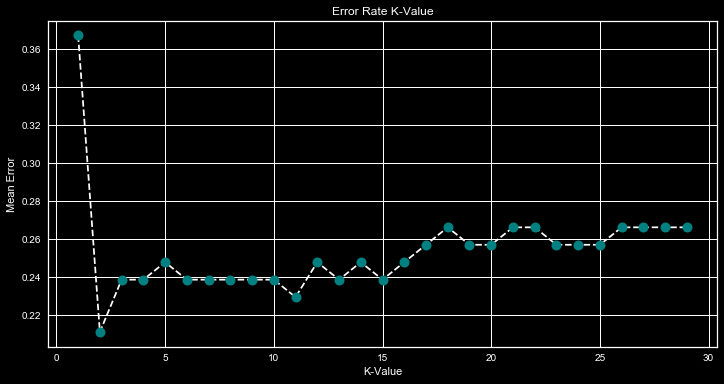

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 30),error, color="white", linestyle="dashed", marker="o",
        markerfacecolor="teal", markersize=10)
plt.title("Error Rate K-Value")
plt.xlabel("K-Value")
plt.ylabel("Mean Error")

In [24]:
display(pd.DataFrame(classification_report(ym_test, ym_pred_knn, output_dict=True)).transpose())

,f1-score,precision,recall,support
0,0.786885,0.705882,0.888889,54.000000
1,0.729167,0.853659,0.636364,55.000000
accuracy,0.761468,0.761468,0.761468,0.761468
macro avg,0.758026,0.779770,0.762626,109.000000
weighted avg,0.757761,0.780448,0.761468,109.000000


LR

In [25]:
lr = LogisticRegression()
lr = lr.fit(xm_train, ym_train)
ym_pred_lr = lr.predict(xm_test)

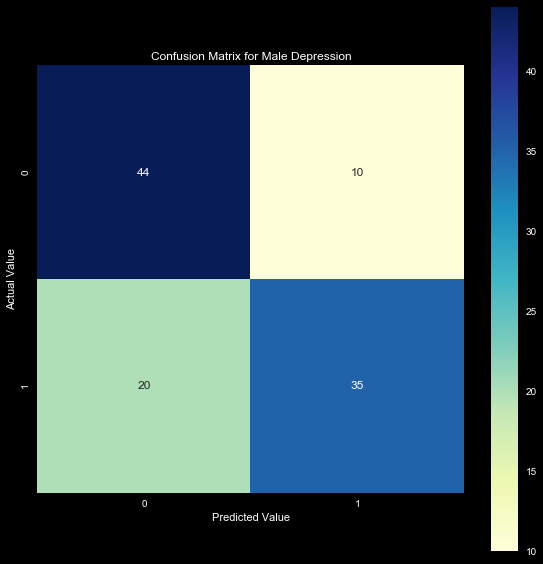

In [26]:
cm(ym_test, ym_pred_lr)

In [27]:
display(pd.DataFrame(classification_report(ym_test, ym_pred_lr, output_dict=True)).transpose())

,f1-score,precision,recall,support
0,0.745763,0.687500,0.814815,54.000000
1,0.700000,0.777778,0.636364,55.000000
accuracy,0.724771,0.724771,0.724771,0.724771
macro avg,0.722881,0.732639,0.725589,109.000000
weighted avg,0.722671,0.733053,0.724771,109.000000


GNB

In [28]:
gnb = GaussianNB()
ym_pred_gnb = gnb.fit(xm_train, ym_train).predict(xm_test)

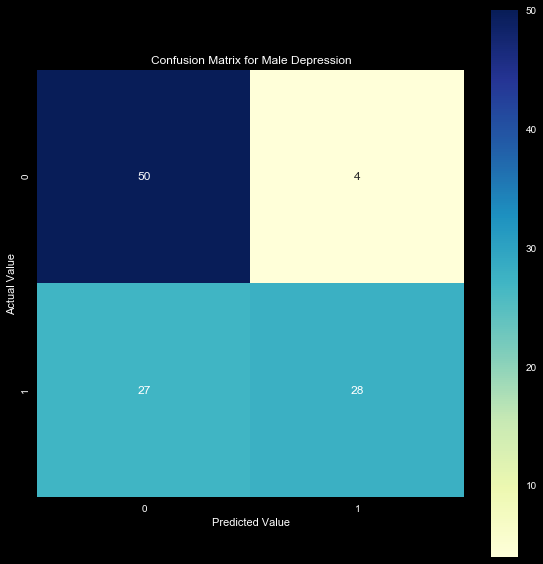

In [29]:
cm(ym_test, ym_pred_gnb)

In [30]:
display(pd.DataFrame(classification_report(ym_test, ym_pred_gnb, output_dict=True)).transpose())

,f1-score,precision,recall,support
0,0.763359,0.649351,0.925926,54.000000
1,0.643678,0.875000,0.509091,55.000000
accuracy,0.715596,0.715596,0.715596,0.715596
macro avg,0.703518,0.762175,0.717508,109.000000
weighted avg,0.702969,0.763210,0.715596,109.000000


DT

In [31]:
dt = DecisionTreeClassifier() # class_weight={0: 87, 1: 13}
dt = dt.fit(xm_train, ym_train)
ym_pred_dt = dt.predict(xm_test)

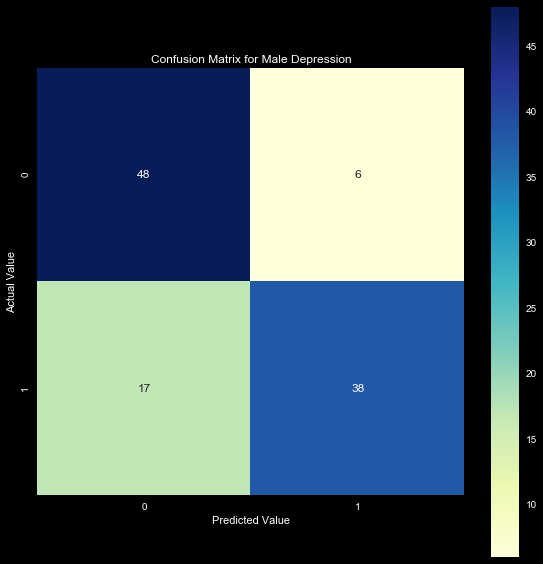

In [32]:
cm(ym_test, ym_pred_dt)

In [33]:
display(pd.DataFrame(classification_report(ym_test, ym_pred_dt, output_dict=True)).transpose())

,f1-score,precision,recall,support
0,0.806723,0.738462,0.888889,54.000000
1,0.767677,0.863636,0.690909,55.000000
accuracy,0.788991,0.788991,0.788991,0.788991
macro avg,0.787200,0.801049,0.789899,109.000000
weighted avg,0.787021,0.801623,0.788991,109.000000


SVM

In [37]:
svmm = svm.SVC(kernel="rbf", probability = True) # , class_weight={0: 87, 1: 13}
svmm.fit(xm_train, ym_train)
y_pred_svm = svmm.predict(xm_test)

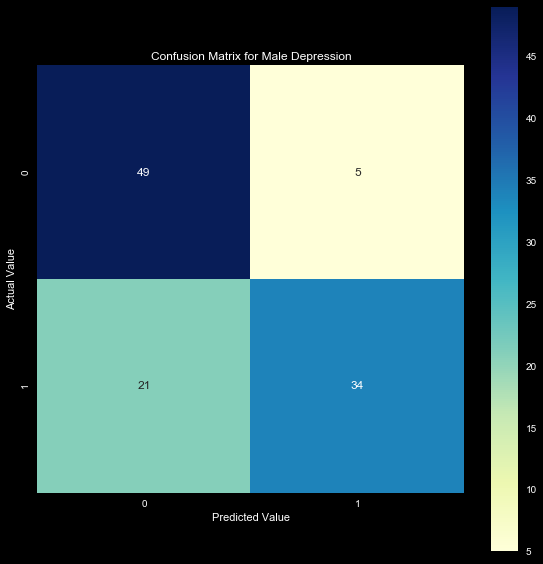

In [38]:
cm(ym_test, y_pred_svm)

In [36]:
display(pd.DataFrame(classification_report(ym_test, y_pred_svm, output_dict=True)).transpose())

,f1-score,precision,recall,support
0,0.776119,0.650000,0.962963,54.000000
1,0.642857,0.931034,0.490909,55.000000
accuracy,0.724771,0.724771,0.724771,0.724771
macro avg,0.709488,0.790517,0.726936,109.000000
weighted avg,0.708877,0.791806,0.724771,109.000000
